In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Creazione dei dati

In [2]:
# Numero casuale
rnd = np.random
rnd.seed(0)

In [3]:
n = 50    # Numero punti vendita
# Bisogna ricordare che il nodo deposito, nella nostra formulazione, corrisponde a D={'s', 't'}
  # con 's' visto come nodo deposito per l'uscita dei veicoli e 'v' come nodo deposito per entrata
# Di conseguenza, poniamo 's'=xc[0] e 't'=xc[n+1]
xc = rnd.rand(n+1)*200      # Vettore di coordinate x dei vari nodi
xc = np.append(xc, xc[0])   # Coordinate x di 't' devono essere uguali alle coordinate x di 's'
yc = rnd.rand(n+1)*100      # Vettore di coordinate y dei vari nodi
yc = np.append(yc, yc[0])   # Coordinate y di 't' devono essere uguali alle coordinate y di 's'

In [4]:
# CREAZIONE DATI

P = [il for il in range(1,n+1)]         # Insieme P dei punti vendita
N = [0] + P + [n+1]                     # Insieme N dei nodi, come unione di P e D={'s','t'}
                                          # 's' corrisponde al nodo 0, mentre 't' corrisponde al nodo n+1

# Insieme A degli archi
# Devo controllare che il nodo i sia differente da j. Inoltre, devo anche controllare di non includere
  # gli archi ('s','t') e ('t','s') poichè sia 's' che 't' corrispondono al nodo deposito
A = [(i,j) for i in N for j in N if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)]

# Costi associati a ogni arco
c = {(i,j): np.random.randint(2,15) for i,j in A}

# Tempo di percorrenza degli archi
# Per semplicità ho posto il tempo di percorrenza come la distanza tra i nodi i e j
t = {(i,j): int(np.hypot(xc[i]-xc[j], yc[i]-yc[j])) for i,j in A}

# Richiesta per ogni nodo
np.random.seed(0)
d = {i: np.random.randint(10,15) for i in P}
d[0] = 0                                    # Nodo deposito 's'
d[n+1] = 0                                  # Nodo deposito 't'

# Finestre di apertura dei punti di vendita
a = {}
b = {}
# Orari depositi
a[0], b[0] = 0, 1500
a[n+1], b[n+1] = 0, 1500
# Divisione in 3 fasce orarie: {[20,480], [50,900], [710, 1450]}
for i in P:
    r = i % 3
    if r == 1:
        a[i], b[i] = 20, 560
    elif r == 2:
        a[i], b[i] = 50, 1200
    else:
        a[i], b[i] = 710, 1450

V = list(range(1, 11))                      # Insieme V dei veicoli
Q = {1:90, 2:90, 3:80, 4:80, 5:90, 6:90,    # Insieme Q delle capacità massime dei veicoli
     7:80, 8:80, 9:90, 10:100}              

# Tempo di servizio
s = {(i,k): np.random.randint(3,5) if i!=0 and i!=n+1 else 0 for i in N for k in V}

In [5]:
print(P)
print(N)
print(xc)
print(yc)
print(A)
print(c)
print(f"t;{t}")
print(d)
print(a)
print(b)
print(s)
print(V)
print(Q)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
[109.76270079 143.03787327 120.55267521 108.9766366   84.73095987
 129.17882261  87.51744225 178.35460016 192.7325521   76.68830377
 158.34500762 105.77898395 113.60891222 185.11932766  14.20721164
  17.42585994   4.04367949 166.52396911 155.63135019 174.00242965
 195.72366845 159.83171284  92.29587245 156.10583526  23.65488517
 127.98420427  28.67065748 188.93378341 104.36966435  82.932388
  52.91112242 154.84673789  91.23006644 113.68678977   3.75796009
 123.52709942 122.41914454 123.38679937 188.7496157  136.36405982
  71.90158011  87.40639076 139.52623919  12.04509433 133.35334309
 134.12757392  42

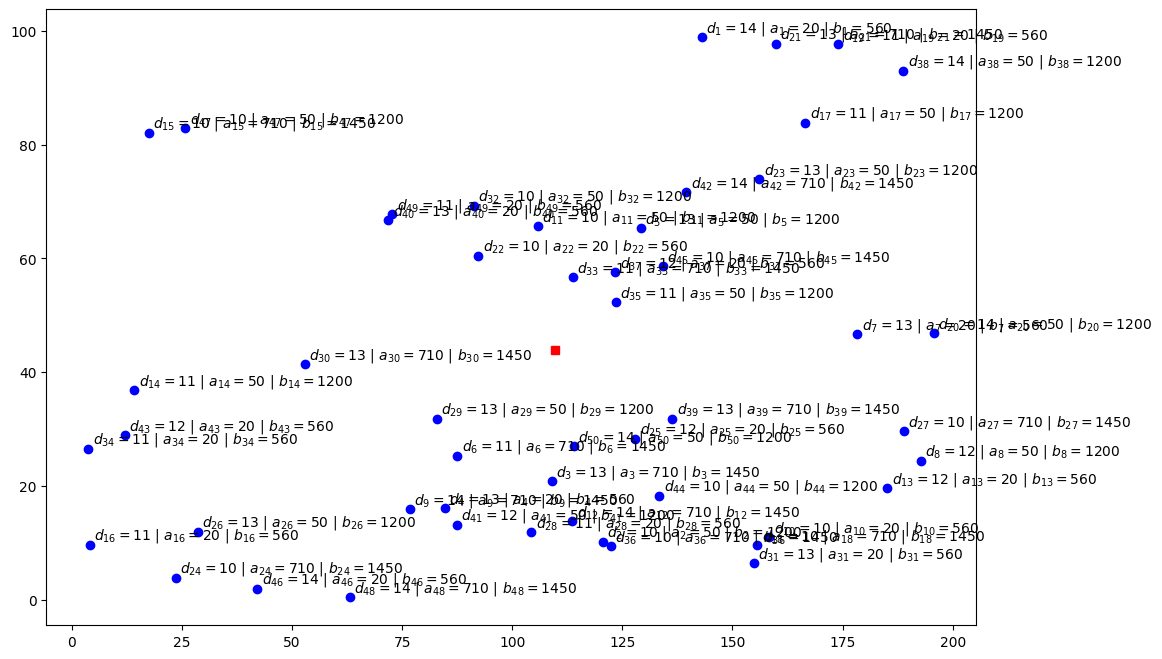

In [6]:
# Visualizzazione deposito e punti vendita
plt.figure(figsize=(12,8))
plt.plot(xc[0], yc[0], c='r', marker='s')     # Nodo deposito
plt.scatter(xc[1:n+1], yc[1:n+1], c='b')          # Nodi punti vendita
for i in P:
  plt.annotate("$d_{%i}=%d$ | $a_{%i}=%d$ | $b_{%i}=%d$" %(i, d[i], i, a[i], i, b[i]), (xc[i]+1, yc[i]+1))

## Algoritmo di Clarke and Wright

In [7]:
# Verifica del vincolo della capacità
def verifica_capacità (rotta, d, capacità):
    domanda_totale = 0
    for i in rotta:
        domanda_totale += d[i]
    return domanda_totale <= capacità 

In [8]:
# Verifica del vincolo sulla finestra temporale
def verifica_finestra (rotta, t, s, a, b, veicolo_id):
    tempo_corrente = 0
    nodo_precedente = 0                     # Deposito di partenza

    for i in rotta:
        tempo_corrente += t[nodo_precedente, i]

        # Nel caso in cui arrivo prima dell'apertura, aspetto
        if tempo_corrente < a[i]:
            tempo_corrente = a[i]

        # Nel caso in cui arrivo dopo la chiusura, non è rispettato il vincolo
        if tempo_corrente > b[i]:
            return False

        # Aggiunta del tempo di servizio
        tempo_corrente += s[i, veicolo_id]
        nodo_precedente = i

    # Verifico se è ritornato al deposito t
    if (nodo_precedente, n+1) in t:
        tempo_corrente += t[nodo_precedente, n+1]
        if tempo_corrente > b[n+1]:
            return False

    return True

In [9]:
# Si trova la rotta che contiene un nodo estremo e il suo indice
def trova_rotta_contenente (i, rotte_attive):
    # Scorro tra i nodi delle rotte attive
    for r_attiva in rotte_attive:
        if i in r_attiva:
            indice = r_attiva.index(i)
            # Si controlla che sia un estremo
            if indice==0 or indice==len(r_attiva)-1:
                return r_attiva, indice
    return None, -1

In [10]:
# Unione delle rotte
def unisci_rotte (rotta_i, rotta_j, indice_i, indice_j):

    # Sono effettuati vari controlli

    # i è l'ultimo di rotta_i, mentre j è il primo di rotta_j
    if indice_i==len(rotta_i)-1 and indice_j==0:
        return rotta_i + rotta_j
    # j è l'ultimo di rotta_j, mentre i è il primo di rotta_i
    elif indice_j==len(rotta_j)-1 and indice_i==0:
        return rotta_j + rotta_i
    # i è l'ultimo di rotta_i, mentre j è l'ultimo di rotta_j
    elif indice_i==len(rotta_i)-1 and indice_j==len(rotta_j)-1:
        return rotta_i + rotta_j[::-1]
    # i è il primo di rotta_i, mentre j è il primo di rotta_j
    elif indice_i==0 and indice_j==0:
        return rotta_i[::-1] + rotta_j
    
    return None

In [11]:
# Funzione helper per contare rotte per veicolo
def conta_rotte_per_veicolo(assegnazione, V):
    conteggio = {k: 0 for k in V}
    for rotta, veicolo in assegnazione.items():
        conteggio[veicolo] += 1
    return conteggio

In [12]:
# Primo step
# Inizializzazione di ogni punto vendita come rotta separata
rotte_attive = [[i] for i in P]

assegnazione = {}          # Lista di associazione di ogni rotta al veicolo

# Distribuzione iniziale bilanciata
for idx, r_attiva in enumerate(rotte_attive):
    # Assegna ciclicamente ai veicoli
    k = V[idx % len(V)]
    # Verifica che il veicolo abbia capacità sufficiente
    if verifica_capacità(r_attiva, d, Q[k]):
        assegnazione[tuple(r_attiva)] = k
    else:
        # Se non ha capacità, cerca un altro veicolo
        for veicolo_alt in V:
            if verifica_capacità(r_attiva, d, Q[veicolo_alt]):
                assegnazione[tuple(r_attiva)] = veicolo_alt
                break

In [13]:
assegnazione

{(1,): 1,
 (2,): 2,
 (3,): 3,
 (4,): 4,
 (5,): 5,
 (6,): 6,
 (7,): 7,
 (8,): 8,
 (9,): 9,
 (10,): 10,
 (11,): 1,
 (12,): 2,
 (13,): 3,
 (14,): 4,
 (15,): 5,
 (16,): 6,
 (17,): 7,
 (18,): 8,
 (19,): 9,
 (20,): 10,
 (21,): 1,
 (22,): 2,
 (23,): 3,
 (24,): 4,
 (25,): 5,
 (26,): 6,
 (27,): 7,
 (28,): 8,
 (29,): 9,
 (30,): 10,
 (31,): 1,
 (32,): 2,
 (33,): 3,
 (34,): 4,
 (35,): 5,
 (36,): 6,
 (37,): 7,
 (38,): 8,
 (39,): 9,
 (40,): 10,
 (41,): 1,
 (42,): 2,
 (43,): 3,
 (44,): 4,
 (45,): 5,
 (46,): 6,
 (47,): 7,
 (48,): 8,
 (49,): 9,
 (50,): 10}

In [14]:
# Secondo step 
# Calcolo savings
savings = []
for i in range(len(N)):
    for j in range(i+1, len(N)):
        if (i,j) in A:
            # Il costo c precedentemente non era stato calcolato per i nodi
                # (0,0), (0,11), (11,0) e (11,11). Di conseguenza è stato necessario escludere 
                # tali nodi
            if i==0 and j==0:                             
                sav = 0
            elif i==0:
                sav = c[j,n+1] - c[i,j]
            elif j==0:
                sav = c[0,i] - c[i,j]
            elif i==n+1 and j==n+1:                   
                sav = 0
            elif i==n+1:
                sav = c[j,n+1] - c[i,j]
            elif j==n+1:
                sav = c[0,i] - c[i,j]
            else:
                sav =c[0,i] + c[j,n+1] - c[i,j]
            savings.append(((N[i], N[j]), sav))

In [15]:
savings

[((0, 1), 9),
 ((0, 2), -4),
 ((0, 3), 4),
 ((0, 4), 4),
 ((0, 5), -2),
 ((0, 6), 1),
 ((0, 7), 2),
 ((0, 8), 1),
 ((0, 9), 10),
 ((0, 10), -4),
 ((0, 11), -3),
 ((0, 12), -1),
 ((0, 13), -10),
 ((0, 14), 10),
 ((0, 15), 3),
 ((0, 16), -3),
 ((0, 17), -9),
 ((0, 18), -3),
 ((0, 19), -4),
 ((0, 20), -6),
 ((0, 21), -1),
 ((0, 22), -6),
 ((0, 23), 2),
 ((0, 24), -6),
 ((0, 25), -1),
 ((0, 26), -7),
 ((0, 27), 0),
 ((0, 28), 0),
 ((0, 29), -1),
 ((0, 30), -2),
 ((0, 31), 6),
 ((0, 32), -2),
 ((0, 33), 6),
 ((0, 34), 0),
 ((0, 35), 4),
 ((0, 36), 3),
 ((0, 37), -9),
 ((0, 38), -1),
 ((0, 39), 3),
 ((0, 40), -3),
 ((0, 41), 3),
 ((0, 42), -6),
 ((0, 43), 4),
 ((0, 44), -1),
 ((0, 45), -8),
 ((0, 46), 7),
 ((0, 47), 4),
 ((0, 48), 2),
 ((0, 49), 1),
 ((0, 50), -1),
 ((1, 2), 10),
 ((1, 3), 2),
 ((1, 4), 4),
 ((1, 5), 2),
 ((1, 6), 0),
 ((1, 7), 11),
 ((1, 8), 13),
 ((1, 9), 13),
 ((1, 10), -2),
 ((1, 11), -7),
 ((1, 12), 0),
 ((1, 13), 3),
 ((1, 14), 8),
 ((1, 15), 6),
 ((1, 16), -3),
 ((1, 

In [16]:
# Ordinamento dei saving in ordine decrescente
savings.sort(key=lambda x: x[1], reverse=True)

In [17]:
savings

[((18, 43), 26),
 ((17, 28), 25),
 ((21, 39), 25),
 ((21, 47), 25),
 ((28, 47), 25),
 ((2, 4), 24),
 ((2, 9), 24),
 ((2, 39), 24),
 ((8, 49), 24),
 ((17, 49), 24),
 ((18, 28), 24),
 ((18, 31), 24),
 ((18, 49), 24),
 ((2, 47), 23),
 ((20, 39), 23),
 ((21, 43), 23),
 ((28, 43), 23),
 ((38, 39), 23),
 ((2, 18), 22),
 ((2, 21), 22),
 ((4, 47), 22),
 ((4, 49), 22),
 ((5, 28), 22),
 ((13, 29), 22),
 ((17, 21), 22),
 ((17, 47), 22),
 ((21, 31), 22),
 ((24, 49), 22),
 ((28, 31), 22),
 ((2, 7), 21),
 ((2, 28), 21),
 ((2, 29), 21),
 ((2, 31), 21),
 ((2, 38), 21),
 ((4, 43), 21),
 ((7, 9), 21),
 ((8, 9), 21),
 ((8, 43), 21),
 ((10, 28), 21),
 ((13, 21), 21),
 ((13, 39), 21),
 ((13, 41), 21),
 ((13, 49), 21),
 ((17, 39), 21),
 ((17, 43), 21),
 ((18, 33), 21),
 ((26, 49), 21),
 ((28, 33), 21),
 ((28, 34), 21),
 ((28, 39), 21),
 ((29, 31), 21),
 ((29, 38), 21),
 ((34, 47), 21),
 ((37, 41), 21),
 ((37, 49), 21),
 ((2, 43), 20),
 ((2, 49), 20),
 ((5, 14), 20),
 ((8, 28), 20),
 ((10, 43), 20),
 ((13, 1

In [18]:
# Terzo step
# Iterazione sui savings

for (i,j),sav_ij in savings:
    if sav_ij <= 0:             # I savings <= 0 possono essere esclusi
        break

    # Si trovano le rotte contenenti i e j come estremi
    rotta_i, indice_i = trova_rotta_contenente(i, rotte_attive)
    rotta_j, indice_j = trova_rotta_contenente(j, rotte_attive)

    # Se non sono stati trovati, si saltano
    if rotta_i is None or rotta_j is None or rotta_i==rotta_j:
        continue

    # Ottieni i veicoli assegnati
    veicolo_i = assegnazione.get(tuple(rotta_i))
    veicolo_j = assegnazione.get(tuple(rotta_j))

    if veicolo_i is None or veicolo_j is None:
        continue

    # Conta le rotte per veicolo
    conteggio_rotte = conta_rotte_per_veicolo(assegnazione, V)

    # Tentativo di unione
    nuova_rotta = unisci_rotte(rotta_i, rotta_j, indice_i, indice_j)

    if nuova_rotta is None:
        continue

    if veicolo_i == veicolo_j:
        veicolo_scelto = veicolo_i
    else:
        # Se veicoli diversi, viene scelto quello con meno rotte
        # o con più capacità se hanno lo stesso numero di rotte
        if conteggio_rotte[veicolo_i] < conteggio_rotte[veicolo_j]:
            veicolo_scelto = veicolo_i
        elif conteggio_rotte[veicolo_i] > conteggio_rotte[veicolo_j]:
            veicolo_scelto = veicolo_j
        else:
            # Scelta del veicolo con maggiore capacità
            if Q[veicolo_i] >= Q[veicolo_j]:
                veicolo_scelto = veicolo_i
            else:
                veicolo_scelto = veicolo_j


    # Quarto step
    # Verifica dei vincoli
    if (verifica_capacità(nuova_rotta, d, Q[veicolo_scelto])) and (verifica_finestra(nuova_rotta, t, s, a, b, veicolo_scelto)):

        # Rimozione delle vecchie rotte
        rotte_attive.remove(rotta_i)
        rotte_attive.remove(rotta_j)
        del assegnazione[tuple(rotta_i)]
        del assegnazione[tuple(rotta_j)]

        # Aggiunta della nuova rotta
        rotte_attive.append(nuova_rotta)
        assegnazione[tuple(nuova_rotta)] = veicolo_scelto

In [19]:
# Quinto step
rotte_per_veicolo = {k: [] for k in V}
for rotta, veicolo in assegnazione.items():
    rotte_per_veicolo[veicolo].append(list(rotta))

rotte_per_veicolo

{1: [[1, 9, 3]],
 2: [],
 3: [],
 4: [[11, 14, 5, 46, 18, 33]],
 5: [],
 6: [[42, 45, 6, 36, 12, 23]],
 7: [[19, 7, 2, 4, 43, 10, 27]],
 8: [[32, 26, 38, 44, 16]],
 9: [[8, 49, 17, 28, 47, 21, 39]],
 10: [[40, 50, 37, 41, 13, 29, 31, 15], [25, 35, 22, 34, 20, 48, 24, 30]]}

In [28]:
# Controllo posteriore del numero di rotte per ogni veicolo
# Nonostante le prevenzioni attuate precedentemente (al momento dell'assegnazione delle rotte ai veicoli),
#   è capitato che alcuni veicoli abbiano più di una rotta, mentre al veicoli 0 rotte, non rispettando i vincoli
#   precedentemente fissati. Di conseguenz, per risolvere questo problema, abbiamo deciso di effettuare un ulteriore controllo,
#   seguendo le seguenti logiche
#       1. Se uno dei veicoli ha più di una rotta e un veicolo ha una sola rotta, assegno una delle 2 rotte al veicolo con 0 rotte
#       2. se uno dei veicoli ha più di una rotta e gli altri veicoli hanno tutti almeno una rotta, unisco le rotte di quel veicolo

# Punto 1
# Controllo quali veicoli hanno più di una rotta e quali hanno 0 rotte
veicoli_senza_rotte = [v for v, r in rotte_per_veicolo.items() if len(r) == 0]
veicoli_con_piu_rotte = [v for v, r in rotte_per_veicolo.items() if len(r) > 1]

# Se esistono veicoli con le caratteristiche sopra specificate, eseguiamo il punto 1
if veicoli_senza_rotte and veicoli_con_piu_rotte:
    veicolo_vuoto = veicoli_senza_rotte[0]
    veicolo_con_rotte = veicoli_con_piu_rotte[0]
    # Spostamento della rotta
    rotta_da_spostare = rotte_per_veicolo[veicolo_con_rotte].pop()
    rotte_per_veicolo[veicolo_vuoto].append(rotta_da_spostare)
    assegnazione[tuple(rotta_da_spostare)] = veicolo_vuoto


# Punto 2
# Eventuale unione delle rotte 
for veicolo, rotte in rotte_per_veicolo.items():
    # Controllo la lunghezza delle rotte
    if len(rotte) > 1:
        print("Maggiore di 1")
        for i in range(len(rotte) - 1):
            rotta_attuale = rotte[i]
            rotta_successiva = rotte[i+1]

            # Unione delle rotte
            nuova_rotta = rotta_attuale + rotta_successiva

            if not verifica_capacità(nuova_rotta, d, Q[veicolo]):
                print("Zompato")
                print(rotte[i])
                                     
            if not verifica_finestra(nuova_rotta, t, s, a, b, veicolo):
                print("Zumpi")

            # Controllo dei vincoli
            if (verifica_capacità(nuova_rotta, d, Q[veicolo]) and verifica_finestra(nuova_rotta, t, s, a, b, veicolo)):

                # Rimozione vecchie rotte
                rotte.remove(rotta_attuale)
                rotte.remove(rotta_successiva)
                del assegnazione[tuple(rotta_attuale)]
                del assegnazione[tuple(rotta_successiva)]

                # Aggiunta nuova rotta
                rotte.append(nuova_rotta)
                assegnazione[tuple(nuova_rotta)] = veicolo

# Si controlla se è possibile avere una soluzione
veicoli_con_piu_rotte = [v for v, r in rotte_per_veicolo.items() if len(r) > 1]
if veicoli_con_piu_rotte:
    print("Non riesco a trovare una soluzione, troppe rotte")
else:
    rotte_per_veicolo = {k: [] for k in V}
    for rotta, veicolo in assegnazione.items():
        rotte_per_veicolo[veicolo].append(list(rotta))

    print(rotte_per_veicolo)

{1: [[1, 9, 3]], 2: [[25, 35, 22, 34, 20, 48, 24, 30]], 3: [], 4: [[11, 14, 5, 46, 18, 33]], 5: [], 6: [[42, 45, 6, 36, 12, 23]], 7: [[19, 7, 2, 4, 43, 10, 27]], 8: [[32, 26, 38, 44, 16]], 9: [[8, 49, 17, 28, 47, 21, 39]], 10: [[40, 50, 37, 41, 13, 29, 31, 15]]}


In [22]:
costo_tot = 0

for veicol, liste_rotte in rotte_per_veicolo.items():
    for rot in liste_rotte:
        print(f"Rotta: {rot}")

        # Considero il caso in cui la rotta ha un solo punto vendita
        if len(rot)==1:
            # Sommo i costi tra l'unico nodo e il deposito
            costo_tot += c[0, rot[0]]
            costo_tot += c[rot[0], n+1]
            print(f"Veicolo {veicol}: 0, {rot[0]}, {n+1}")
        else:
            # Calcolo il costo del nodo iniziale
            costo_tot += c[0, rot[0]]
            print(f"Veicolo {veicol}: 0, {rot[0]} (costo: {c[0,rot[0]]})")

            # Calcolo i costi tra i nodi della rotta
            for nodo in range(len(rot)-1):
                i,j = rot[nodo], rot[nodo+1]
                costo_tot += c[i,j]
                print(f"Veicolo {veicol}: {i}, {j} (costo: {c[i,j]})")

            # Calcolo il costo del nodo finale
            costo_tot += c[rot[-1], n+1]
            print(f"Veicolo {veicol}: {rot[-1]}, {n+1} (costo: {c[rot[-1],n+1]})")

print(f"Costo totale: {costo_tot}")

Rotta: [1, 9, 3]
Veicolo 1: 0, 1 (costo: 4)
Veicolo 1: 1, 9 (costo: 5)
Veicolo 1: 9, 3 (costo: 11)
Veicolo 1: 3, 51 (costo: 6)
Rotta: [25, 35, 22, 34, 20, 48, 24, 30]
Veicolo 2: 0, 25 (costo: 7)
Veicolo 2: 25, 35 (costo: 4)
Veicolo 2: 35, 22 (costo: 5)
Veicolo 2: 22, 34 (costo: 2)
Veicolo 2: 34, 20 (costo: 9)
Veicolo 2: 20, 48 (costo: 2)
Veicolo 2: 48, 24 (costo: 6)
Veicolo 2: 24, 30 (costo: 5)
Veicolo 2: 30, 51 (costo: 6)
Rotta: [11, 14, 5, 46, 18, 33]
Veicolo 4: 0, 11 (costo: 6)
Veicolo 4: 11, 14 (costo: 3)
Veicolo 4: 14, 5 (costo: 10)
Veicolo 4: 5, 46 (costo: 3)
Veicolo 4: 46, 18 (costo: 11)
Veicolo 4: 18, 33 (costo: 2)
Veicolo 4: 33, 51 (costo: 9)
Rotta: [42, 45, 6, 36, 12, 23]
Veicolo 6: 0, 42 (costo: 9)
Veicolo 6: 42, 45 (costo: 4)
Veicolo 6: 45, 6 (costo: 4)
Veicolo 6: 6, 36 (costo: 3)
Veicolo 6: 36, 12 (costo: 2)
Veicolo 6: 12, 23 (costo: 6)
Veicolo 6: 23, 51 (costo: 4)
Rotta: [19, 7, 2, 4, 43, 10, 27]
Veicolo 7: 0, 19 (costo: 8)
Veicolo 7: 19, 7 (costo: 8)
Veicolo 7: 7, 2 (cos

In [23]:
for veicol, liste_rotte in rotte_per_veicolo.items():
    for rot in liste_rotte:
        costo_rotta = 0
        domanda_rotta = 0
        print(rot)
        for nodo in range(len(rot)-1):
            i,j = rot[nodo], rot[nodo+1]
            print(f"Veicolo {veicolo}: arco ({i},{j})")
            costo_rotta += c[i,j]
            domanda_rotta += d[i]
        
        if costo_rotta <= Q[veicol]:
            print(f"Veicolo {veicol} rispetta il vincolo di capacità di {Q[veicol]}, con domanda totale pari a {domanda_rotta}")

[1, 9, 3]
Veicolo 6: arco (1,9)
Veicolo 6: arco (9,3)
Veicolo 1 rispetta il vincolo di capacità di 90, con domanda totale pari a 28
[25, 35, 22, 34, 20, 48, 24, 30]
Veicolo 6: arco (25,35)
Veicolo 6: arco (35,22)
Veicolo 6: arco (22,34)
Veicolo 6: arco (34,20)
Veicolo 6: arco (20,48)
Veicolo 6: arco (48,24)
Veicolo 6: arco (24,30)
Veicolo 2 rispetta il vincolo di capacità di 90, con domanda totale pari a 82
[11, 14, 5, 46, 18, 33]
Veicolo 6: arco (11,14)
Veicolo 6: arco (14,5)
Veicolo 6: arco (5,46)
Veicolo 6: arco (46,18)
Veicolo 6: arco (18,33)
Veicolo 4 rispetta il vincolo di capacità di 80, con domanda totale pari a 58
[42, 45, 6, 36, 12, 23]
Veicolo 6: arco (42,45)
Veicolo 6: arco (45,6)
Veicolo 6: arco (6,36)
Veicolo 6: arco (36,12)
Veicolo 6: arco (12,23)
Veicolo 6 rispetta il vincolo di capacità di 90, con domanda totale pari a 59
[19, 7, 2, 4, 43, 10, 27]
Veicolo 6: arco (19,7)
Veicolo 6: arco (7,2)
Veicolo 6: arco (2,4)
Veicolo 6: arco (4,43)
Veicolo 6: arco (43,10)
Veicolo 6

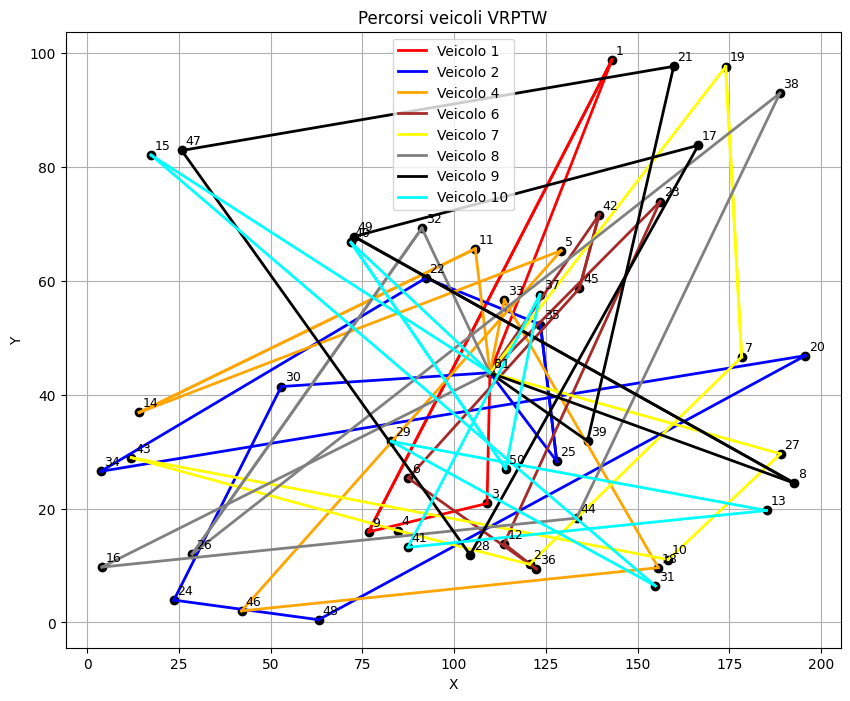

In [25]:
# Colori per i veicoli
colori = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'yellow', 'grey', 'black', 'cyan']

plt.figure(figsize=(10, 8))

# Disegna i nodi
for i in N:
  plt.plot(xc[i], yc[i], 'ko')
  plt.text(xc[i]+1, yc[i]+1, str(i), fontsize=9)

for k, liste_rotte in rotte_per_veicolo.items():
    for rot in liste_rotte:
        for nodo in range(len(rot)):
            if nodo==0:
                plt.plot([xc[0], xc[rot[nodo]]], [yc[0], yc[rot[nodo]]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')
                plt.plot([xc[rot[nodo]], xc[rot[nodo+1]]], [yc[rot[nodo]], yc[rot[nodo+1]]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')
            if nodo==len(rot)-1:
                plt.plot([xc[rot[nodo]], xc[n+1]], [yc[rot[nodo]], yc[n+1]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')
            else:
                plt.plot([xc[rot[nodo]], xc[rot[nodo+1]]], [yc[rot[nodo]], yc[rot[nodo+1]]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')

# Evita duplicati nella legenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Percorsi veicoli VRPTW")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()
           